<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Chapter_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
!pip install -q mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util

     |████████████████████████████████| 122kB 2.7MB/s 


In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#1. Form dollar bars on E-mini S&P 500 futures:

In [4]:
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [5]:
dollar_bars.head()

,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.79,51.07,50.710,51.07,19844
2009-09-28 09:53:49,51.07,51.15,51.050,51.14,20324
2009-09-28 09:55:26,51.14,51.15,51.129,51.14,19622
2009-09-28 10:02:52,51.14,51.26,51.080,51.25,22319
2009-09-28 10:10:21,51.25,51.29,51.190,51.29,21519


## (a) Quantize the returns series using the binary method.

a stream of
returns rt can be encoded according to the sign, 1 for rt > 0, 0 for rt < 0, removing
cases where rt = 0.

In [0]:
df = dollar_bars[['close']]

In [7]:
df['ret'] = np.log(df.close).diff()
df=df.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df['bin_encod']=np.nan

df.loc[df.ret>0,'bin_encod']=1
df.loc[df.ret<0,'bin_encod']=0

df2=df.dropna()

In [9]:
df2.head()

,close,ret,bin_encod
date_time,,,
2009-09-28 09:53:49,51.14,0.001370,1.0
2009-09-28 10:02:52,51.25,0.002149,1.0
2009-09-28 10:10:21,51.29,0.000780,1.0
2009-09-28 10:19:36,51.23,-0.001171,0.0
2009-09-28 10:24:23,51.25,0.000390,1.0


##(b) Quantize the returns series using the quantile encoding, using 10 letters.

In [10]:
df['quant_encod']=pd.qcut(df.ret, q=10, labels=range(1,11))
df.head()

,close,ret,bin_encod,quant_encod
date_time,,,,
2009-09-28 09:53:49,51.14,0.001370,1.0,9
2009-09-28 09:55:26,51.14,0.000000,NaN,5
2009-09-28 10:02:52,51.25,0.002149,1.0,10
2009-09-28 10:10:21,51.29,0.000780,1.0,8
2009-09-28 10:19:36,51.23,-0.001171,0.0,2


## (c) Quantize the returns series using the sigma encoding, where 𝜎 is the standard deviation of all bar returns.

In [11]:
x = df.ret.min()
base = [x]
while df.ret.max() > x:
    x += df.ret.std()
    base.append(x)

df['sigma_encod'] = np.digitize(df.ret, base)
df

,close,ret,bin_encod,quant_encod,sigma_encod
date_time,,,,,
2009-09-28 09:53:49,51.14,0.001370,1.0,9,120
2009-09-28 09:55:26,51.14,0.000000,NaN,5,120
2009-09-28 10:02:52,51.25,0.002149,1.0,10,120
2009-09-28 10:10:21,51.29,0.000780,1.0,8,120
2009-09-28 10:19:36,51.23,-0.001171,0.0,2,119
...,...,...,...,...,...
2019-06-28 15:58:59,116.56,-0.000858,0.0,2,119
2019-06-28 15:59:02,116.57,0.000086,1.0,6,120
2019-06-28 15:59:45,116.56,-0.000086,0.0,5,120


In [12]:
df.sigma_encod.value_counts()

120    37666
119    15734
121     2777
118     1224
122      444
117      275
123      137
116      110
124       72
115       42
125       32
114       18
113       14
126       13
111        5
128        5
112        5
127        5
129        4
110        3
109        3
108        3
106        2
222        1
99         1
151        1
1          1
97         1
130        1
102        1
131        1
145        1
135        1
107        1
149        1
96         1
Name: sigma_encod, dtype: int64

In [13]:
import math
math.ceil(( df.ret.max()-df.ret.min() )/ df.ret.std())

222

In [14]:
df.sigma_encod.max()

222

## (d) Compute the entropy of the three encoded series, using the plug-in method.

In [0]:
def plugIn(msg,w):
    pmf=pmf1(msg,w)
    out=-sum([pmf[i]*np.log2(pmf[i]) for i in pmf])/w 
    return out,pmf

def pmf1(msg,w):
    lib={} 
    if not isinstance(msg,str): msg=''.join(map(str,msg)) 
    for i in range(w,len(msg)): 
        msg_=msg[i-w:i] 
        if msg_ not in lib:lib[msg_]=[i-w] 
        else:lib[msg_]=lib[msg_]+[i-w] 
    pmf=ﬂoat(len(msg)-w) 
    pmf={i:len(lib[i])/pmf for i in lib} 
    return pmf

In [16]:
plugIn(df.bin_encod, w=100)[0]

0.17422902458497488

In [17]:
plugIn(df.quant_encod,w=100)[0]

0.15974033609198546

In [18]:
plugIn(df.sigma_encod, w=100)[0]

0.173731080960602

## (e) Compute the entropy of the three encoded series, using Kontoyiannis’ method, with a window size of 100.

In [0]:
def matchLength(msg,i,n):
    # Maximum matched length+1, with overlap.
    # i>=n & len(msg)>=i+n
    subS=''
    for l in range(n):
        msg1=msg[i:i+l+1]
        for j in range(i-n,i):
            msg0=msg[j:j+l+1]
            if msg1==msg0:
                subS=msg1
                break # search for higher l.
    return len(subS)+1,subS # matched length + 1

def konto(msg,window=None):
    """
    * Kontoyiannis’ LZ entropy estimate, 2013 version (centered window).
    * Inverse of the avg length of the shortest non-redundant substring.
    * If non-redundant substrings are short, the text is highly entropic.
    * window==None for expanding window, in which case len(msg)%2==0
    * If the end of msg is more relevant, try konto(msg[::-1])
    """
    out={'num':0,'sum':0,'subS':[]}
    if not isinstance(msg,str):
        msg = ''.join(map(str,msg))
        if window is None:
            points = range(1,len(msg)/2+1)
        else:
            window = min(window,len(msg)/2)
            points = range(window,len(msg)-window+1)
        for i in points:
            if window is None:
                l,msg_ = matchLength(msg,i,i)
                out['sum'] += np.log2(i+1)/l # to avoid Doeblin condition
            else:
                l,msg_ = matchLength(msg,i,window)
                out['sum'] += np.log2(window+1)/l # to avoid Doeblin condition
            out['subS'].append(msg_)
            out['num'] += 1
        out['h']=out['sum']/out['num']
        out['r']=1-out['h']/np.log2(len(msg)) # redundancy, 0<=r<=1
        return out

In [20]:
konto(df.bin_encod,window=100)['h']

0.5383269676743115

In [21]:
konto(df.quant_encod,window=100)['h']

2.3644591659386207

In [22]:
konto(df.sigma_encod,window=100)['h']

0.6252739495152874

해설:

# 2. Using the bars from exercise 1:

## (a) Compute the returns series, {rt}.

In [0]:
ret = df[['ret']]

##(b) Encode the series as follows: 0 if rtrt−1 < 0, and 1 if rtrt−1 ≥ 0.

In [0]:
ret['tmp']=ret.ret*ret.ret.shift(-1)
ret.dropna(inplace=True)

In [133]:
ret['encode'] = 1
ret.loc[ret.tmp < 0, 'encode'] =0
ret.drop(['tmp'],axis=1,inplace=True)
ret.head()

,ret,encode
date_time,,
2009-09-28 09:53:49,0.001370,1
2009-09-28 09:55:26,0.000000,1
2009-09-28 10:02:52,0.002149,1
2009-09-28 10:10:21,0.000780,0
2009-09-28 10:19:36,-0.001171,0


## (c) Partition the series into 1000 non-overlapping subsets of equal size (you may have to drop some observations at the beginning).



not enough data, so i got 100 subsets instead

In [134]:
len(ret)/100

586.05

In [135]:
ret_=ret.iloc[5:]
len(ret_)

58600

In [0]:
chunks = [ret_[x:x+586] for x in range(0, len(ret_), 586)]

In [137]:
chunks[0].encode

date_time
2009-09-28 10:24:23    1
2009-09-28 10:34:30    0
2009-09-28 10:45:25    0
2009-09-28 11:10:57    0
2009-09-28 11:24:29    0
                      ..
2009-11-24 13:08:34    0
2009-11-24 13:34:28    1
2009-11-24 14:00:56    0
2009-11-24 14:33:14    1
2009-11-24 14:41:43    1
Name: encode, Length: 586, dtype: int64

##(d) Compute the entropy of each of the 1000 encoded subsets, using the plugin method.
##(e) Compute the entropy of each of the 1000 encoded subsets, using the Kontoyiannis method, with a window size of 100.

In [0]:
ent_plug=[]
for i in range(0,100):
  ent_plug.append(plugIn(chunks[i].encode,w=100)[0])

ent_kon=[]
for i in range(0,100):
  ent_kon.append(konto(chunks[i].encode,window=100)['h'])

## (f) Compute the correlation between results 2.d and 2.e.

In [142]:
resultf = pd.DataFrame({'plugin':ent_plug,'konto':ent_kon})
resultf.head()

,plugin,konto
0,0.089248,0.886276
1,0.089248,0.863965
2,0.089248,0.898317
3,0.089248,0.883224
4,0.089248,0.874946


In [141]:
resultf.corr()

,plugin,konto
plugin,1.000000e+00,1.365105e-15
konto,1.365105e-15,1.000000e+00


해설:

# 3. Draw 1000 observations from a standard Normal distribution:

In [0]:
snd = np.random.normal(0,1,1000)

## (a) What is the true entropy of this process?

$H = {1\over2}log|2\pi e \sigma^2|_{\sigma^2=1} \approx 1.42$

In [103]:
h = 1/2*np.log(abs(2*np.pi*np.e*snd.std()))
h.round(2)

1.42

##(b) Label the observations according to 8 quantiles.


In [104]:
quant = pd.qcut(snd, q=8, labels = range(1,9))
quant

[5, 4, 6, 5, 8, ..., 2, 4, 2, 2, 5]
Length: 1000
Categories (8, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7 < 8]

##(c) Estimate the entropy using the plug-in method.


In [105]:
plugIn(quant,w=100)[0]

0.0981378119121713

##(d) Estimate the entropy using the Kontoyiannis method:
(i) using a window size of 10.
(ii) using a window size of 100.

In [106]:
#(i)
konto(quant,window=10)['h']

2.1095127362577264

In [107]:
#(ii)
konto(quant,window=100)['h']

2.3352229037299943

해설: 

# 4. Using the draws from exercise 3, {xt}t=1,…,1000:

##(a) Compute yt = 𝜌yt−1 + xt, where 𝜌 = .5, y0 = 0.

In [151]:
len(x)

1000

In [150]:
y = [0]
for i in range(len(snd)) : y.append(0.5*y[-1]+snd[i])
len(y)

1001

In [0]:
y=y[0:1000]

## (b) Label {y_t} the observations according to 8 quantiles.

In [0]:
quanty = pd.qcut(y,q=8,labels=range(1,9))

##(c) Estimate the entropy using the plug-in method.


In [156]:
plugIn(quanty,w=100)[0]

0.0981378119121713

##(d) Estimate the entropy using the Kontoyiannis method
(i) using a window size of 10.
(ii) using a window size of 100.

In [157]:
#(i)
konto(quanty,window=10)['h']

2.079042668435694

In [158]:
#(ii)
konto(quanty,window=100)['h']

2.2885548617695646

해설:

# 5. Suppose a portfolio of 10 holdings with equal dollar allocations.

#(a) 
The portion of the total risk contributed by the ith principal component is
1/10
, i = 1,…, 10. What is the portfolio’s entropy?

**From Meucci(2009), Portfolio Concentration**

$$ H = 1-{1\over N}exp\left\{\sum_{i=1}^N\theta_i log(\theta_i)\right\} $$

In [0]:
def H(N,risk):
  ret = 1-(1/N)*np.exp(np.sum(risk*np.log(risk)))
  return ret

In [0]:
risk_a = np.ones(10)*1/10

In [165]:
H(10,risk_a)

0.99

## (b) 
The portion of the total risk contributed by the ith principal component is
1 − i/55
, i = 1,…, 10. What is the portfolio’s entropy?

In [173]:
risk_b= []
for i in range(1,11): risk_b.append(1-i/55)
risk_b

[0.9818181818181818,
 0.9636363636363636,
 0.9454545454545454,
 0.9272727272727272,
 0.9090909090909091,
 0.8909090909090909,
 0.8727272727272728,
 0.8545454545454545,
 0.8363636363636364,
 0.8181818181818181]

In [174]:
H(10,risk_b)

0.9606658852848915

## (c) 
The portion of the total risk contributed by the ith principal component
is 𝛼
1
10 + (1 − 𝛼)(1 − i
55
), i = 1,…, 10, 𝛼 ∈ [0, 1]. Plot the portolio’s
entropy as a function of 𝛼.

In [0]:
def entropy(alpha):
  risk_c=[]
  for i in range(1,11):risk_c.append( alpha/10 + (1-alpha)*(1-i/55) )
  return H(10,risk_c)

In [0]:
alpha = np.linspace(0,1,1000)
h = [entropy(a) for a in alpha]

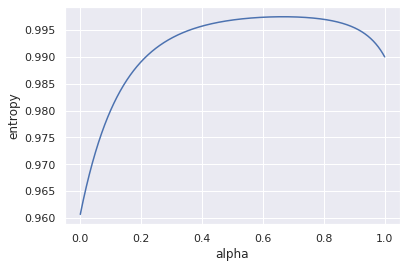

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.plot(alpha,h)
plt.ylabel('entropy')
plt.xlabel('alpha')
plt.show()